# Modeling

This notebook shows how to construct machine learning models for the project, which contains the following parts:

1. Initialization of machine learning models.

2. Train-validate split for walk-forward validation.

3. Data Preprocessing.

4. Time-series reformating.

5. Model training and evaluation.

6. Output visualization.

In [43]:
# import libraries
import pandas as pd
import numpy as np

# for the model
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor#, HistGradientBoostingRegressor

# Import user defined libraries
import sys
sys.path.append("..")
from preprocessing.data_loader import DataLoader
from preprocessing.preprocessor import DataPreprocessor
from forecast_formatting.supervised_formatting import SupervisedFormatter
from model_applying.forecasting import Forecaster
from model_applying.prediction import Predictor
from utils.visualization import CurveVisualizer, BarVisualizer
from evaluation.error_list import ErrorList

## Initialization of machine learning models

Considering that we have observed linear and non-linear correlations between variables of different types, we think it is a good choice to use ensemble methods for modeling. As a comparison, we also add a simple linear regression model.

In this notebook, we choose the following three models:

1. linear regression;

2. random forest;

3. stacking (lasso and random forest as base models, the other random forest as the final predictor).

The performance of other models can also be added to the list of models.

In [44]:
def get_models(models=dict()):
	# models
    max_depth = 10
    n_estimators = 50
    models['Linear Regression'] = LinearRegression()
    models['Random Forest'] = RandomForestRegressor(n_estimators=20, max_depth=10,random_state=0)
    models['Stacking'] = StackingRegressor(estimators=[('rf', RandomForestRegressor(n_estimators=20, max_depth=10, random_state=0)),
        ('lr', Lasso()),],
        final_estimator=RandomForestRegressor(n_estimators=20,max_depth=4, random_state=0),
                                     passthrough=True)
    
    #models['GB'] = GradientBoostingRegressor(random_state=0, n_estimators=20, max_depth=10, learning_rate=0.6)
    #models['AB'] = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), random_state=0, n_estimators=n_estimators)
    #models['BG'] = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=n_estimators, random_state=0)
    #models['DT'] = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    print('Defined %d models' % len(models))
    return models

## Train and evaluate models

We explore two kinds of problems which are:

1. Prediction

2. Forecasting

***Prediction*** is to predict the sales of the current moments with current features.

***Forecasting*** is to predict the sales of the current moments and the future moment with current and previous features/observations.
To study the problem of forecasting, we first generate lag variables to reformat the dataset and to convert the problem as supervised learning.


In [45]:
def train_models(data, numerical, valid_step=1, past_step=2, validation_size=20, error_metrics={'MSE', 'MAE'}):
    # keep the length of training and test set
    data_size = len(data)

    # initialize models, predictions, and errors
    model_list = get_models()
    error_list = ErrorList(model_list.keys(), error_metrics)
    predict_list, predict_list_train = dict(), dict()

    # train and validate each models
    for model_key in model_list.keys():
        model = model_list[model_key]
        predict_list[model_key], predict_list_train[model_key] = [], []

        # perform walk-forward validation
        min_train_size = data_size - validation_size
        for split_point in range(min_train_size, data_size, valid_step):
            # split training and validation sets with sliding windows
            X_train = data.drop('y', axis=1).iloc[:split_point]
            y_train = data[['y']].iloc[:split_point]
            X_valid = data.drop('y', axis=1).iloc[split_point-past_step:split_point+valid_step] #slice for forecasting is longer than that for prediction
            y_valid = data[['y']].iloc[split_point-past_step:split_point+valid_step]

            # preprocess data
            feature_processor = DataPreprocessor()
            feature_processor.set_preprocessors(len(X_train['name'].unique()))
            X_train, y_train = feature_processor.fit_transform(X_train, y_train)
            X_valid = feature_processor.transform(X_valid)


            # create lag variables
            formatter = SupervisedFormatter()
            X_train_t, y_train_f, y_train_t = formatter.format_train(X_train, y_train, t_lag=past_step, t_out=1)
            X_valid_t, y_valid_f, y_valid_t = formatter.format_valid(X_valid, y_valid, t_lag=past_step, t_out=valid_step)

            # feature_selection    
            week_dummies = [var for var in X_train.columns if 'week' in var]                     
            remarks_dummies = [var for var in X_train.columns if 'remarks' in var]
            event_dummies = [var for var in X_train.columns if 'event' in var]
            weather_dummies = [var for var in X_train.columns if 'weather' in var]
            numerical_dsc = [var + '_dsc' for var in numerical]

            selected_features =  ['temperature_dsc', 'remarks_fun']

            selected_features_t = ['%s(t)'%var for var in selected_features]
            for i in range(0, past_step):
                selected_features_t += ['%s(t-%d)'%(var, i+1) for var in ['temperature_dsc']]#'temperature_dsc'

            X_train_t = X_train_t[selected_features_t]
            X_valid_t = X_valid_t[selected_features_t]

            X_train_t, X_valid_t = X_train_t.astype(float), X_valid_t.astype(float)

            X_train_t = X_train_t.join(y_train_f)
            X_valid_t = X_valid_t.join(y_valid_f)

            
            # train and evaluate models
            if past_step == 0:
                predictor = Predictor(model)
                y_train_preds, y_valid_preds = predictor.train_infer(X_train_t, y_train_t.values.reshape(-1,),  X_valid_t)
            else:
                predictor = Forecaster(model, t_lag=past_step, t_out=valid_step)
                y_train_preds, y_valid_preds = predictor.train_infer_recursive(X_train_t, y_train_t.values.reshape(-1,),  X_valid_t)


            y_valid_t = y_valid_t.values.reshape(-1,1)

            # evaluate performance of models
            error_list.update(model_key, y_train_t, y_train_preds, y_valid_t, y_valid_preds)
            
            # store predicts of models
            predict_list[model_key] += list(y_valid_preds)

        # store training predicts of models
        predict_list_train[model_key] = y_train_preds.reshape(-1,)[:min_train_size-past_step]

        # output evaluation results
        for m in error_metrics:
            print('Model ({}) -- train {}: {}'.format(model_key, m, error_list.errors[model_key]['train'][m].avg))
        print('Model ({}) -- train {}: {}'.format(model_key, 'RMSE', error_list.errors[model_key]['train']['RMSE']))
        print()
        for m in error_metrics:
            print('Model ({}) -- valid {}: {}'.format(model_key, m, error_list.errors[model_key]['valid'][m].avg))
        print('Model ({}) -- valid {}: {}'.format(model_key, 'RMSE', error_list.errors[model_key]['valid']['RMSE']))
        print("-"*70)

    return predict_list_train, predict_list, error_list.errors

### Set directory and parameters

In [46]:
    # set directory
    data_dir, output_dir  = "../data/", "../../outputs/"

    # Set parameters
    past_step, valid_step = 2, 2 # the length of lagging, 0 for predicting, >0 for forecasting; the length of outputs for forecasting
    validation_size = 20 # keep the last (validation_size) of items for validation
    error_metrics = {'MSE', 'MAE'}

### Load dataset and perform basic preprocessing


In [47]:
    # Load datasets
    training_path = data_dir + "train.csv"
    test_path = data_dir + "test.csv"
    sample_path = data_dir + "sample.csv"
    loader = DataLoader(training_path)
    data = loader.preprocess()


    # find categorical, numerical, and discrete variables
    categorical, numerical, discrete, datetime = loader.get_types()

### Train and validate models for prediction

Since we do not use previous features and observations for prediction, ```past_step``` is set to ```0```.

The function returns ```prediction_train```(predictions of the training set),
 ```prediction```(predictions of the validation set), and ```p_errors``` (errors evaluated on both training and validation sets).

In [48]:
    # test prediction models
    prediction_train, prediction, p_errors = train_models(data, numerical, valid_step=valid_step, past_step=0)

Defined 3 models
Model (Linear Regression) -- train MAE: 17.557745084328225
Model (Linear Regression) -- train MSE: 525.9927545017573
Model (Linear Regression) -- train RMSE: 22.934531922447366

Model (Linear Regression) -- valid MAE: 15.824111131078226
Model (Linear Regression) -- valid MSE: 327.56101508247093
Model (Linear Regression) -- valid RMSE: 18.098646774896483
----------------------------------------------------------------------
Model (Random Forest) -- train MAE: 14.515374290576416
Model (Random Forest) -- train MSE: 376.9236872817765
Model (Random Forest) -- train RMSE: 19.414522587016567

Model (Random Forest) -- valid MAE: 10.327324525949011
Model (Random Forest) -- valid MSE: 171.07586745796243
Model (Random Forest) -- valid RMSE: 13.079597373694744
----------------------------------------------------------------------
Model (Stacking) -- train MAE: 16.41464985379267
Model (Stacking) -- train MSE: 475.5652163682367
Model (Stacking) -- train RMSE: 21.80745781534924

Mode

### Train and validate models for forecasting

Since we do not use previous features and observations for prediction, ```past_step``` is set to ```2```.

The function returns ```forecast_train```(forecast results of the training set),
 ```forecast```(forecast results of the validation set), and ```f_errors``` (errors evaluated on both training and validation sets).

In [49]:
    # test forecast models
    forecast_train, forecast, f_errors = train_models(data, numerical, valid_step=valid_step, past_step=past_step)

Defined 3 models
Model (Linear Regression) -- train MAE: 15.049403274951143
Model (Linear Regression) -- train MSE: 354.5201567732266
Model (Linear Regression) -- train RMSE: 18.828705658468046

Model (Linear Regression) -- valid MAE: 11.612759808947464
Model (Linear Regression) -- valid MSE: 170.8588805472365
Model (Linear Regression) -- valid RMSE: 13.07129987978382
----------------------------------------------------------------------
Model (Random Forest) -- train MAE: 6.026854428983654
Model (Random Forest) -- train MSE: 62.928707376499084
Model (Random Forest) -- train RMSE: 7.9327616487890955

Model (Random Forest) -- valid MAE: 9.811411912188717
Model (Random Forest) -- valid MSE: 142.0281370742835
Model (Random Forest) -- valid RMSE: 11.917555834745793
----------------------------------------------------------------------
Model (Stacking) -- train MAE: 11.665839303621324
Model (Stacking) -- train MSE: 218.81631251279717
Model (Stacking) -- train RMSE: 14.792441059973745

Model

## Visualization of results

In [50]:
# set color map 
colors = [[68/255, 94/255, 126/255],
          [226/255, 117/255, 0/255],
          [0/255, 152/255, 166/255],
          [255/255, 124/255, 143/255],
          [153/255, 102/255, 0/255],
          [17/255, 137/255, 123/255],
          [134/255, 20/255, 112/255]]

### Visualize the curves of prediction results with groundtruth and ```remarks```

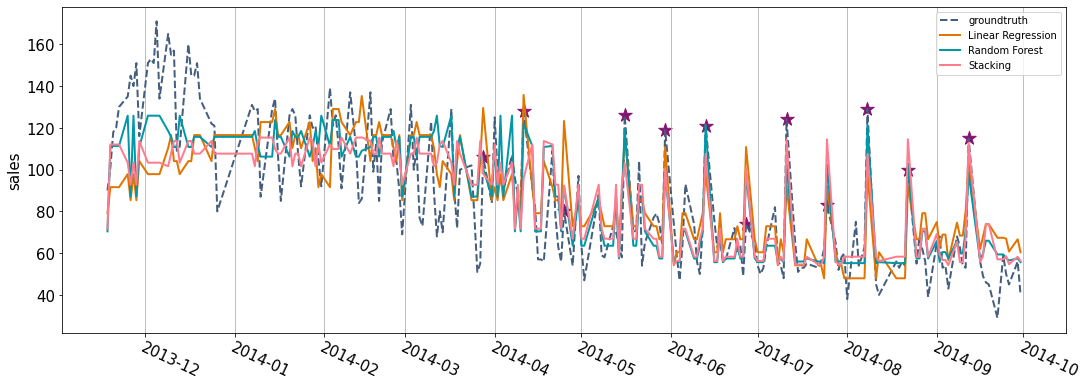

In [51]:
curve_visualizer = CurveVisualizer(colors, figsize=(18, 6), markersize=200)
curve_visualizer.show_predictions(data, prediction, pred_train=prediction_train, show_marks=('remarks','お楽しみメニュー' ), show=True, savepath=None)

### Visualize the curves of errors of prediction results on the validation set

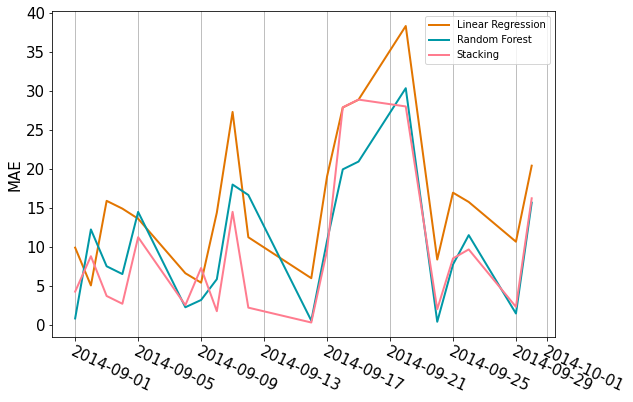

In [52]:
curve_visualizer = CurveVisualizer(colors, figsize=(18, 6), markersize=200)
curve_visualizer.show_metric(data, p_errors, show=True, metric_key='MAE', savepath=None)

### Compare MAE of different methods

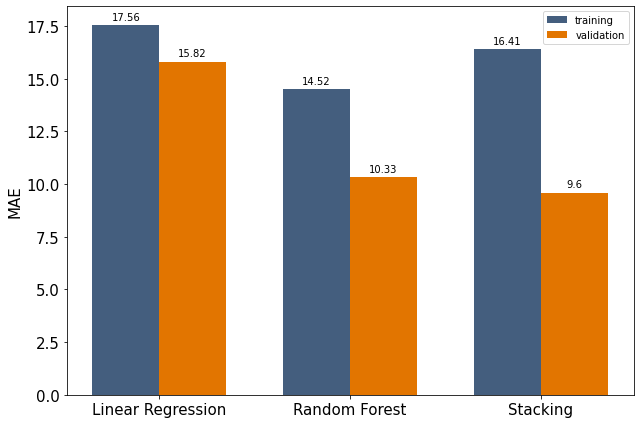

In [53]:
bar_visualizer = BarVisualizer(colors)
bar_visualizer.show_train_valid_errors(p_errors, metric_key='MAE', show=True, savepath=None)

### Compare RMSE of different methods

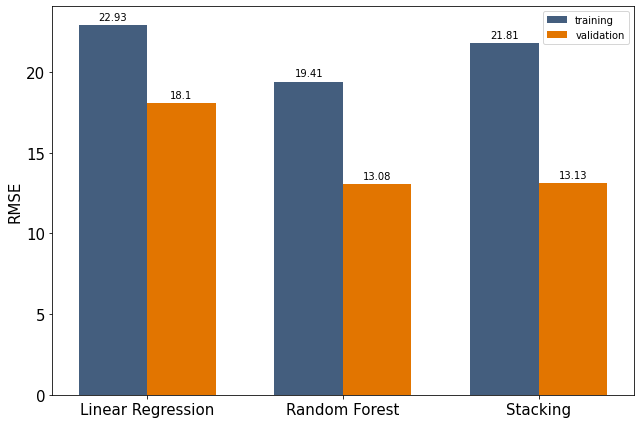

In [54]:
bar_visualizer = BarVisualizer(colors)
bar_visualizer.show_train_valid_errors(p_errors, metric_key='RMSE', show=True, savepath=None)

### Compare RMSE of different methods for prediction and forecasting

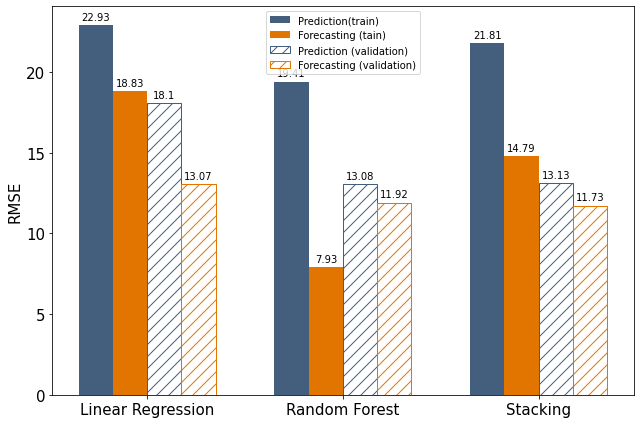

In [55]:
bar_visualizer = BarVisualizer(colors)
bar_visualizer.show_predict_forecast_errors(p_errors, f_errors, metric_key='RMSE', show=True, savepath=None)

## Conclusion

1. ```temperature``` and ```remarks``` are two of the most influential variables for sales.

2. Forecasting with Random Forest achieves the lowest RMSE of ```11.92``` on the validation set.

3. An alternative strategy to improve the performance is to add more features like ```weather```, ```event```, etc. 
(Prediction with a bagging model achieves the RMSE of ```6.31```) 


